In [1]:
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import numpy as np 
import pickle
from numpy import pi
import operator

creator.create("obj", base.Fitness, weights=(1.0,))
creator.create("Ind", list, fitness=creator.obj)

In [2]:
checkpoint_file = "checkpoint.pkl"
with open(checkpoint_file, "rb") as cp_file:
    cp = pickle.load(cp_file)

In [3]:
cp["input_file"]

{'evaluators': {'openmc_gc': {'execute2': [['aprun -n 19 -d 32 openmc -s 32',
     '']],
   'inputs': ['total_pf', 'sine_a', 'sine_b', 'sine_c'],
   'input_script': ['aprun -n 1 -d 1 -- bwpy-environ -- python',
    'fhr_plank_openmc.py'],
   'order': 0,
   'output_script': ['aprun -n 1 -d 1 -- bwpy-environ -- python',
    'fhr_plank_openmc_keff.py'],
   'outputs': ['total_pf', 'keff2'],
   'keep_files': True}},
 'constraints': {'keff2': {'constrained_val': [1.39], 'operator': ['>=']}},
 'control_variables': {'sine_b': {'max': 1.57, 'min': 0.0},
  'total_pf': {'max': 0.04, 'min': 0.02},
  'sine_c': {'max': 6.28, 'min': 0.0},
  'sine_a': {'max': 2.0, 'min': 0.0}},
 'algorithm': {'selection_operator': {'operator': 'selTournament',
   'inds': 15,
   'tournsize': 5},
  'generations': 10,
  'parallel': 'none',
  'objective': ['min'],
  'mutation_probability': 0.23,
  'pop_size': 60,
  'mating_operator': {'operator': 'cxBlend', 'alpha': 0.46},
  'optimized_variable': ['total_pf'],
  'mating_p

In [4]:
def get_ind_list(pop_list, index):
    ind_list = [] 
    for pop in pop_list:
        ind_list.append(pop[index])
    return ind_list

In [5]:
logbook = cp["logbook"]

In [6]:
def plot_1_obj(logbook, index, obj_name, short_name, save_fig, save_fig_title):
    gen = np.array(logbook.select("gen")) + 1
    obj_avg = get_ind_list(logbook.chapters["oup"].select("avg"), index)
    obj_std = get_ind_list(logbook.chapters["oup"].select("std"), index)
    obj_min = get_ind_list(logbook.chapters["oup"].select("min"), index)
    obj_max = get_ind_list(logbook.chapters["oup"].select("max"), index)
    plt.rc('font', family='serif')
    fig, ax = plt.subplots(figsize=(15,7))
    ax.errorbar(gen, obj_avg, yerr=obj_std, label="Ave "+ short_name, capsize=5)
    ax.plot(gen, obj_min, "*-", label="Min "+ short_name)
    ax.plot(gen, obj_max, "*-", label="Max "+ short_name)
    ax.set_xlabel("Generation [#]", fontsize=20)
    ax.set_ylabel(obj_name + " ("+short_name+") [-]", fontsize=18)
    ax.grid()
    handles, labels = ax.get_legend_handles_labels()
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.legend(handles, labels, fontsize=18, bbox_to_anchor = [1.0, 1.0])
    ax.set_title(obj_name + " Evolution", fontsize=24)
    if save_fig:
        plt.savefig(save_fig_title,bbox_inches='tight', dpi=300)

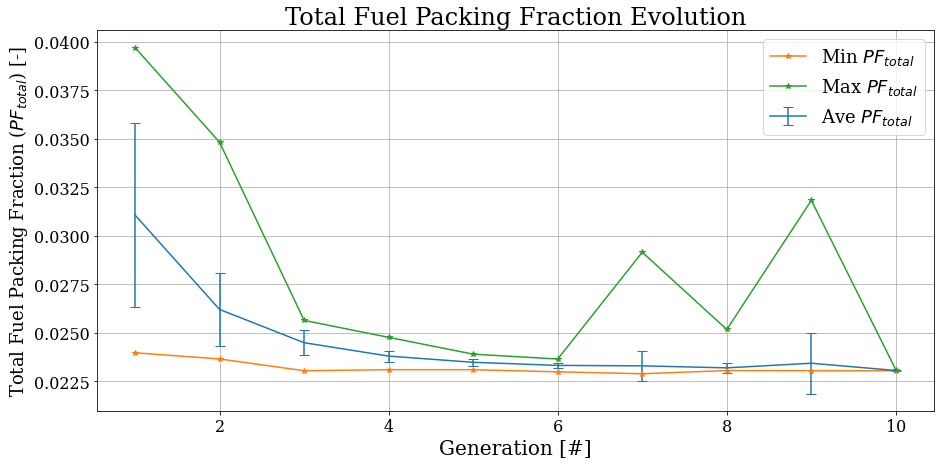

In [7]:
plot_1_obj(logbook, 0, "Total Fuel Packing Fraction", "$PF_{total}$", True, "slab-obj-1-pf-evol.png")

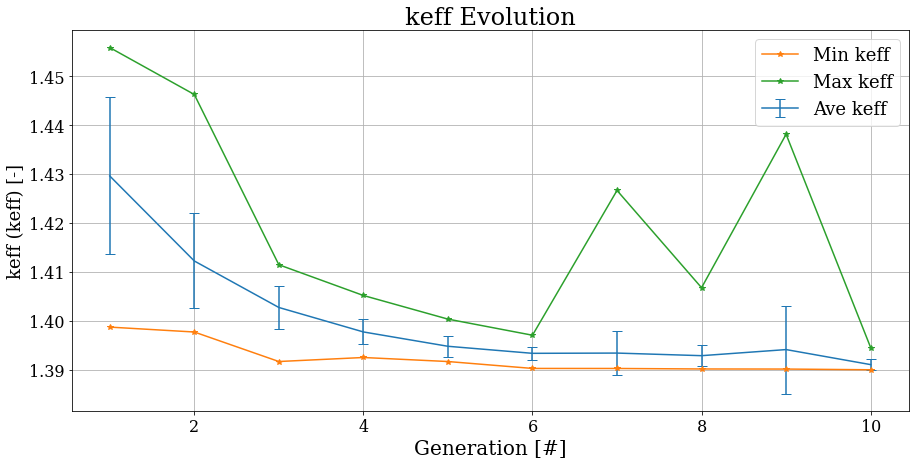

In [8]:
plot_1_obj(logbook, 1, "keff", "keff", False, "")

In [9]:
def sine_curve(ind, pf_present):
    if pf_present:
        pf, a, b, c = ind[0], ind[1], ind[2], ind[3]
    else:
        a, b, c = ind[0], ind[1], ind[2]
        pf = 0.0979
    boundaries = np.arange(2,27.1,2.31)
    midpoints = [] 
    for x in range(len(boundaries)-1):
        midpoints.append((boundaries[x]+boundaries[x+1])/2)
    midpoints = np.array(midpoints)
    x = midpoints
    x1 = np.arange(2, 24.8, 0.01)
    T_pitch = 0.09266
    vol_total = 23.1 * 2.55 * T_pitch * 20
    vol_triso = 4 / 3 * np.pi * 4235e-5 ** 3
    no_trisos = pf * vol_total / vol_triso
    vol_slice = 2.31 * 2.55 * T_pitch * 20
    sine = a * np.sin(b*x + c) + 2
    sine1 = a * np.sin(b*x1 + c) + 2
    sine1 = sine1 / sum(sine) * no_trisos * vol_triso / vol_slice
    sine = sine / sum(sine) * no_trisos * vol_triso / vol_slice
    return x, sine, x1, sine1 

[0.02303964400672609, 1.8642813578611792, 1.2753113243811485, 0.9554286427745831]


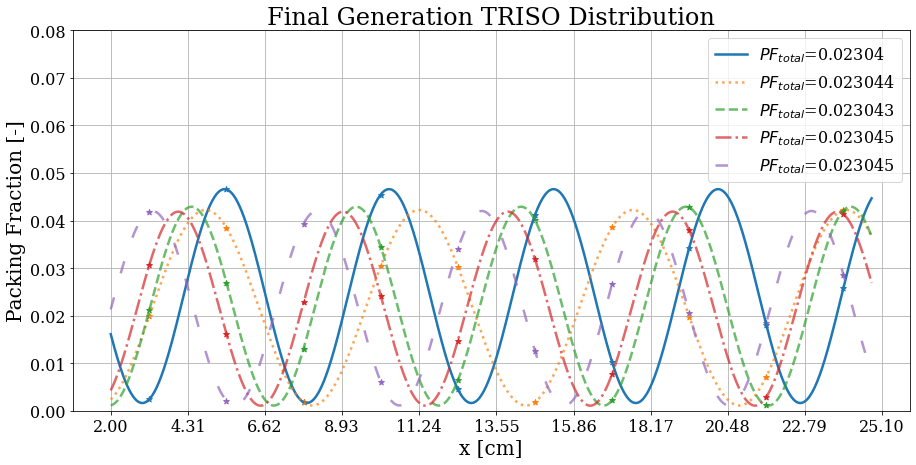

In [10]:
results = cp["all"]
plt.rc('font', family='serif')
fig, ax = plt.subplots(figsize=(15,7))
colors = 2*["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan", "tab:blue","tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
line_styles = ["-", ":", "--", "-.", (0, (5, 10))]
oup_results = results["outputs"]
count = 0
for i, pop in enumerate(results["populations"]):
    obj_0 = np.array([item[0] for item in oup_results[i]])
    sorted_index_0 = np.argsort(obj_0)
    if i == 9:
        for j, ind in enumerate(pop):
            if j == sorted_index_0[0]:
                print(ind)
                x, sine, x1, sine1 = sine_curve(ind, True)
                ax.scatter(x, sine, marker='*', color=colors[count])
                ax.plot(x1, sine1, alpha=1, label="$PF_{total}$="+str(round(ind[0],6)),
                        linestyle=line_styles[count], color=colors[count], linewidth=2.5)
                count += 1
            if j in sorted_index_0[1:5]:
                x, sine, x1, sine1 = sine_curve(ind, True)
                ax.scatter(x, sine, marker='*', color=colors[count])
                ax.plot(x1, sine1, alpha=0.7, label="$PF_{total}$="+str(round(ind[0],6)),
                        linestyle=line_styles[count], color=colors[count], linewidth=2.5)
                count += 1
ax.grid()
ax.set_ylim(0.00,0.08)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=16, bbox_to_anchor = [1.0, 1.0])
ax.set_xticks(np.arange(2,27.1,2.31))
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel("x [cm]", fontsize=20)
ax.set_ylabel("Packing Fraction [-]", fontsize=20)
ax.set_title('Final Generation TRISO Distribution', fontsize=24)
plt.savefig("slab-obj-1-pf-final.png",bbox_inches='tight', dpi=300)

Text(0.5, 1.0, 'Final Generation TRISO Distribution')

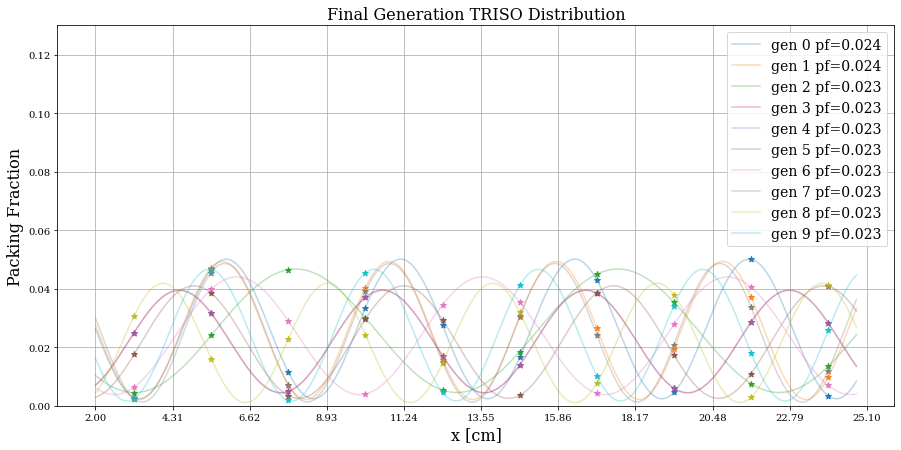

In [11]:
results = cp["all"]
plt.rc('font', family='serif')
fig, ax = plt.subplots(figsize=(15,7))
colors = 2*["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan", "tab:blue","tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
oup_results = results["outputs"]
for i, pop in enumerate(results["populations"]):
    obj_0 = np.array([item[0] for item in oup_results[i]])
    sorted_index_0 = np.argsort(obj_0)
    if i >= 0:
        for j, ind in enumerate(pop):
            if j == sorted_index_0[0]:
                x, sine, x1, sine1 = sine_curve(ind, True)
                ax.scatter(x, sine, marker='*')
                ax.plot(x1, sine1, alpha=0.3, label="gen "+ str(i)+ " pf=" + str(round(ind[0],3)))
                
ax.grid()
ax.set_ylim(0.00,0.13)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14, bbox_to_anchor = [1.0, 1.0])
ax.set_xticks(np.arange(2,27.1,2.31))
ax.set_xlabel("x [cm]", fontsize=16)
ax.set_ylabel("Packing Fraction", fontsize=16)
ax.set_title('Final Generation TRISO Distribution', fontsize=16)

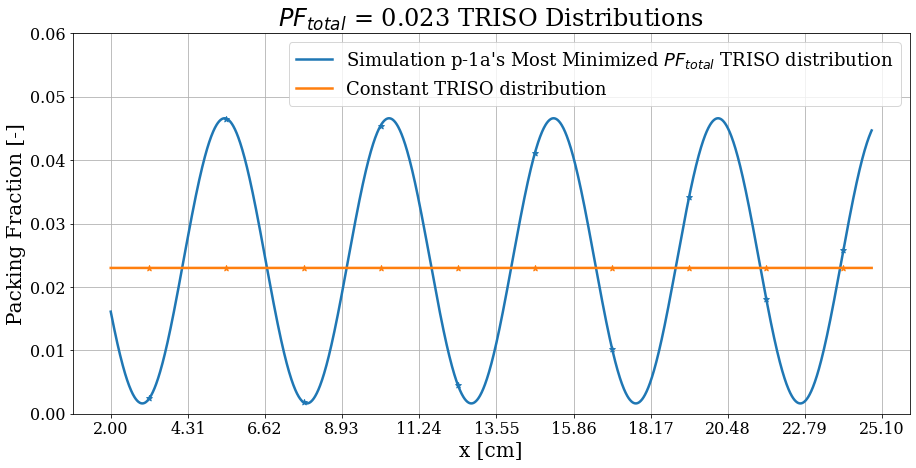

In [12]:
results = cp["all"]
plt.rc('font', family='serif')
fig, ax = plt.subplots(figsize=(15,7))
colors = 2*["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan", "tab:blue","tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
final_oup_results = results["outputs"][-1]
final_pop = results["populations"][-1]
obj_0 = np.array([item[0] for item in final_oup_results])
sorted_index_0 = np.argsort(obj_0)
for j, ind in enumerate(final_pop):
    if j == sorted_index_0[0]:
        x, sine, x1, sine1 = sine_curve(ind, True)
        ax.scatter(x, sine, marker='*')
        ax.plot(x1, sine1, alpha=1, linewidth=2.5, label=r"Simulation p-1a's Most Minimized $PF_{total}$ TRISO distribution")
ax.scatter(x, [0.023]*10, marker='*')
ax.plot(x1, [0.023]*len(x1), label="Constant TRISO distribution", linewidth=2.5)
ax.grid()
ax.set_ylim(0.00,0.06)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18, bbox_to_anchor = [1.0, 1.0])
ax.set_xticks(np.arange(2,27.1,2.31))
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel("x [cm]", fontsize=20)
ax.set_ylabel("Packing Fraction [-]", fontsize=20)
ax.set_title(r'$PF_{total}$ = 0.023 TRISO Distributions', fontsize=24)
plt.savefig("triso-0.023.png",bbox_inches='tight', dpi=300)
